Input:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [3]:
#%cd ..

In [4]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *

## Optimization Settings

In [5]:
start_time='2020-03-05'
end_time='2020-06-30'
observations=['Confirmed_cases', 'Admissions_hospital'] # ['Number_of_deaths', 'Confirmed_cases', 'Admissions_hospital']

dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [6]:
df_obs_initial = pd.read_csv('data/observations_03022022.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, observations=observations)
observed = torch.tensor(df_obs['Confirmed_cases'], requires_grad=False, device=device, dtype=dtype)
print(initial_newly_infected)
df_obs.head(3)

[1 1 4 4 3]


,Date,Confirmed_cases,Admissions_hospital
0,2020-03-05,10,1
1,2020-03-06,2,4
2,2020-03-07,9,0


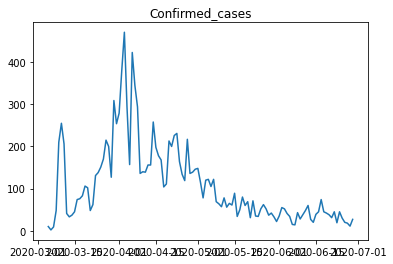

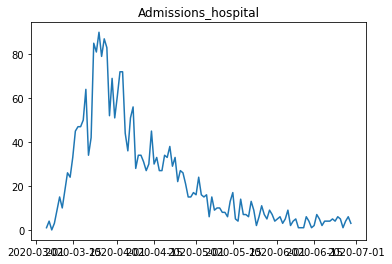

In [7]:
for observation in observations:
  plt.plot(df_obs['Date'], df_obs[observation])
  plt.title(observation)
  plt.show()

## Initialize Model Parameter

### Initialize Helper Parameter

In [8]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_observations = df_obs.shape[0]
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)

### Initialize to be optimized Model Parameter

In [9]:
method = RandomWalk(num_observations,device,dtype)

## Initialize alpha and phi

In [10]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(-0.0746, device='cuda:0', requires_grad=True),
  'phi': tensor(-0., device='cuda:0', requires_grad=True)},
 'real_values': {'alpha': tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>),
  'phi': tensor(25., device='cuda:0', grad_fn=<AddBackward0>)}}

# Optimization

## Training

Step: 0, Time: 0.12807822227478027, Loss: 307289.78125, Mean Expected Daily Hospit: 78.90494537353516


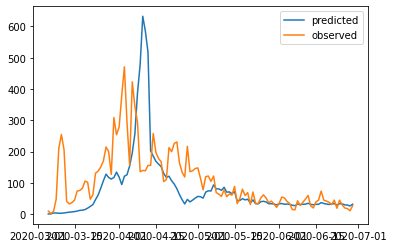

Step: 5, Time: 0.12055468559265137, Loss: 255474.3125, Mean Expected Daily Hospit: 63.315093994140625
Step: 10, Time: 0.12237811088562012, Loss: 248790.484375, Mean Expected Daily Hospit: 60.61661911010742
Step: 15, Time: 0.12227702140808105, Loss: 239107.53125, Mean Expected Daily Hospit: 65.78113555908203
Step: 20, Time: 0.11762046813964844, Loss: 225994.46875, Mean Expected Daily Hospit: 72.50531768798828
Step: 25, Time: 0.1268765926361084, Loss: 214345.125, Mean Expected Daily Hospit: 77.58428955078125
Step: 30, Time: 0.11797571182250977, Loss: 203455.5, Mean Expected Daily Hospit: 78.69115447998047
Step: 35, Time: 0.11964011192321777, Loss: 192167.28125, Mean Expected Daily Hospit: 77.6796646118164
Step: 40, Time: 0.12429499626159668, Loss: 180864.796875, Mean Expected Daily Hospit: 78.53145599365234
Step: 45, Time: 0.12241411209106445, Loss: 169424.0, Mean Expected Daily Hospit: 82.24079895019531
Step: 50, Time: 0.1310558319091797, Loss: 158442.578125, Mean Expected Daily Hospit:

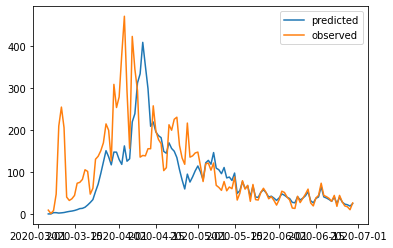

Step: 55, Time: 0.12863993644714355, Loss: 147800.390625, Mean Expected Daily Hospit: 87.40399169921875
Step: 60, Time: 0.12061429023742676, Loss: 137589.546875, Mean Expected Daily Hospit: 88.06399536132812
Step: 65, Time: 0.1304035186767578, Loss: 127858.5234375, Mean Expected Daily Hospit: 89.8126449584961
Step: 70, Time: 0.12486934661865234, Loss: 118726.171875, Mean Expected Daily Hospit: 91.40153503417969
Step: 75, Time: 0.12294340133666992, Loss: 110164.9375, Mean Expected Daily Hospit: 92.05840301513672
Step: 80, Time: 0.12250971794128418, Loss: 102227.265625, Mean Expected Daily Hospit: 93.03421783447266
Step: 85, Time: 0.12493348121643066, Loss: 94945.2734375, Mean Expected Daily Hospit: 94.38773345947266
Step: 90, Time: 0.12381815910339355, Loss: 88333.4296875, Mean Expected Daily Hospit: 95.1119613647461
Step: 95, Time: 0.11809563636779785, Loss: 82397.671875, Mean Expected Daily Hospit: 95.56930541992188
Step: 100, Time: 0.12340354919433594, Loss: 77128.984375, Mean Expect

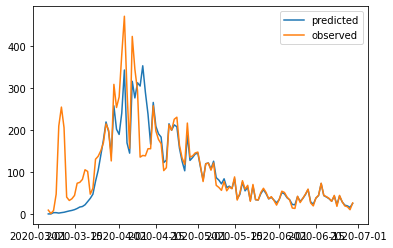

Step: 105, Time: 0.11610269546508789, Loss: 72491.484375, Mean Expected Daily Hospit: 96.64542388916016
Step: 110, Time: 0.12451553344726562, Loss: 68432.5234375, Mean Expected Daily Hospit: 96.9413070678711
Step: 115, Time: 0.12257695198059082, Loss: 64890.6171875, Mean Expected Daily Hospit: 97.32606506347656
Step: 120, Time: 0.1261742115020752, Loss: 61798.859375, Mean Expected Daily Hospit: 97.54806518554688
Step: 125, Time: 0.12448573112487793, Loss: 59093.88671875, Mean Expected Daily Hospit: 97.68995666503906
Step: 130, Time: 0.12123918533325195, Loss: 56719.0234375, Mean Expected Daily Hospit: 97.87570190429688
Step: 135, Time: 0.12871217727661133, Loss: 54624.80859375, Mean Expected Daily Hospit: 97.99404907226562
Step: 140, Time: 0.12256979942321777, Loss: 52769.85546875, Mean Expected Daily Hospit: 98.10836791992188
Step: 145, Time: 0.137115478515625, Loss: 51120.1328125, Mean Expected Daily Hospit: 98.22506713867188
Step: 150, Time: 0.1232001781463623, Loss: 49648.171875, M

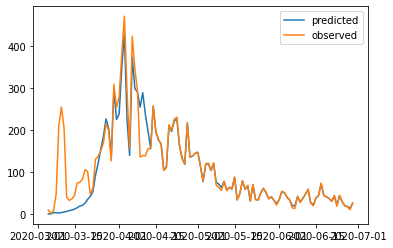

Step: 155, Time: 0.12176942825317383, Loss: 48331.95703125, Mean Expected Daily Hospit: 98.37850189208984
Step: 160, Time: 0.11919546127319336, Loss: 47153.28125, Mean Expected Daily Hospit: 98.45270538330078
Step: 165, Time: 0.12759113311767578, Loss: 46096.3359375, Mean Expected Daily Hospit: 98.51428985595703
Step: 170, Time: 0.12385010719299316, Loss: 45146.84375, Mean Expected Daily Hospit: 98.57783508300781
Step: 175, Time: 0.11935734748840332, Loss: 44291.65234375, Mean Expected Daily Hospit: 98.62556457519531
Step: 180, Time: 0.12192630767822266, Loss: 43518.828125, Mean Expected Daily Hospit: 98.67179107666016
Step: 185, Time: 0.12411022186279297, Loss: 42817.76171875, Mean Expected Daily Hospit: 98.7143783569336
Step: 190, Time: 0.125715970993042, Loss: 42179.234375, Mean Expected Daily Hospit: 98.75106048583984
Step: 195, Time: 0.12422299385070801, Loss: 41595.40625, Mean Expected Daily Hospit: 98.78713989257812
Step: 200, Time: 0.12547612190246582, Loss: 41059.62109375, Mea

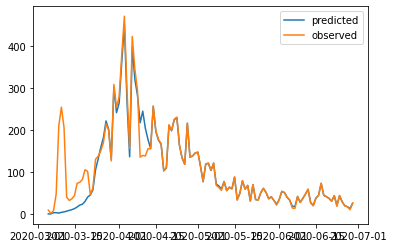

Step: 205, Time: 0.11843156814575195, Loss: 40566.21484375, Mean Expected Daily Hospit: 98.8498764038086
Step: 210, Time: 0.12282443046569824, Loss: 40110.3515625, Mean Expected Daily Hospit: 98.88032531738281
Step: 215, Time: 0.13616609573364258, Loss: 39687.83203125, Mean Expected Daily Hospit: 98.91050720214844
Step: 220, Time: 0.1213676929473877, Loss: 39295.02734375, Mean Expected Daily Hospit: 98.94058990478516
Step: 225, Time: 0.12577533721923828, Loss: 38928.7890625, Mean Expected Daily Hospit: 98.97050476074219
Step: 230, Time: 0.11950254440307617, Loss: 38586.33984375, Mean Expected Daily Hospit: 99.00098419189453
Step: 235, Time: 0.1229238510131836, Loss: 38265.2421875, Mean Expected Daily Hospit: 99.0312728881836
Step: 240, Time: 0.12395310401916504, Loss: 37963.34765625, Mean Expected Daily Hospit: 99.06179809570312
Step: 245, Time: 0.11942291259765625, Loss: 37678.796875, Mean Expected Daily Hospit: 99.09236907958984
Step: 250, Time: 0.1200864315032959, Loss: 37409.886718

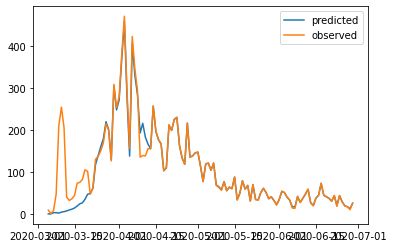

Step: 255, Time: 0.12485361099243164, Loss: 37155.125, Mean Expected Daily Hospit: 99.15320587158203
Step: 260, Time: 0.12379860877990723, Loss: 36913.19140625, Mean Expected Daily Hospit: 99.18340301513672
Step: 265, Time: 0.1212921142578125, Loss: 36682.89453125, Mean Expected Daily Hospit: 99.2137222290039
Step: 270, Time: 0.12316560745239258, Loss: 36463.16015625, Mean Expected Daily Hospit: 99.24382019042969
Step: 275, Time: 0.12208414077758789, Loss: 36253.03125, Mean Expected Daily Hospit: 99.27433776855469
Step: 280, Time: 0.12918615341186523, Loss: 36051.640625, Mean Expected Daily Hospit: 99.30467224121094
Step: 285, Time: 0.11814689636230469, Loss: 35858.203125, Mean Expected Daily Hospit: 99.33525848388672
Step: 290, Time: 0.12652802467346191, Loss: 35672.0234375, Mean Expected Daily Hospit: 99.3661117553711
Step: 295, Time: 0.12347698211669922, Loss: 35492.4375, Mean Expected Daily Hospit: 99.39704132080078
Step: 300, Time: 0.12403035163879395, Loss: 35318.8828125, Mean Ex

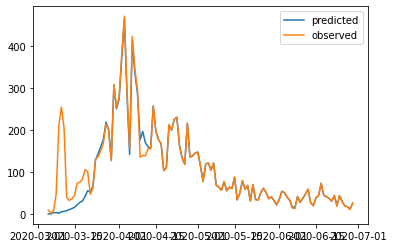

Step: 305, Time: 0.12206721305847168, Loss: 35150.8203125, Mean Expected Daily Hospit: 99.46005249023438
Step: 310, Time: 0.12401509284973145, Loss: 34987.76953125, Mean Expected Daily Hospit: 99.49191284179688
Step: 315, Time: 0.12047982215881348, Loss: 34829.3046875, Mean Expected Daily Hospit: 99.52413940429688
Step: 320, Time: 0.13067626953125, Loss: 34675.0234375, Mean Expected Daily Hospit: 99.55670928955078
Step: 325, Time: 0.1189124584197998, Loss: 34524.5703125, Mean Expected Daily Hospit: 99.58975982666016
Step: 330, Time: 0.12501907348632812, Loss: 34377.609375, Mean Expected Daily Hospit: 99.62296295166016
Step: 335, Time: 0.12712383270263672, Loss: 34233.859375, Mean Expected Daily Hospit: 99.65654754638672
Step: 340, Time: 0.3842661380767822, Loss: 34093.0390625, Mean Expected Daily Hospit: 99.6906967163086
Step: 345, Time: 0.19913768768310547, Loss: 33954.921875, Mean Expected Daily Hospit: 99.72508239746094
Step: 350, Time: 0.21174073219299316, Loss: 33819.27734375, Mea

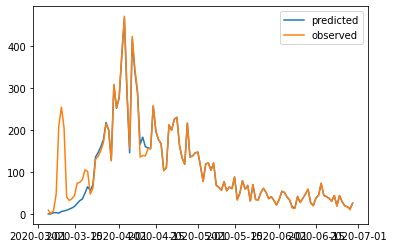

Step: 355, Time: 0.22807836532592773, Loss: 33685.91796875, Mean Expected Daily Hospit: 99.79525756835938
Step: 360, Time: 0.20715069770812988, Loss: 33554.6640625, Mean Expected Daily Hospit: 99.83090209960938
Step: 365, Time: 0.38030099868774414, Loss: 33425.3515625, Mean Expected Daily Hospit: 99.8670883178711
Step: 370, Time: 0.4021031856536865, Loss: 33297.8671875, Mean Expected Daily Hospit: 99.90338897705078
Step: 375, Time: 0.22320771217346191, Loss: 33172.0390625, Mean Expected Daily Hospit: 99.9404525756836
Step: 380, Time: 0.13198614120483398, Loss: 33047.8046875, Mean Expected Daily Hospit: 99.97767639160156
Step: 385, Time: 0.11896443367004395, Loss: 32925.03515625, Mean Expected Daily Hospit: 100.015380859375
Step: 390, Time: 0.1199338436126709, Loss: 32803.65625, Mean Expected Daily Hospit: 100.05329132080078
Step: 395, Time: 0.12375235557556152, Loss: 32683.580078125, Mean Expected Daily Hospit: 100.0917739868164
Step: 400, Time: 0.12484931945800781, Loss: 32564.7480468

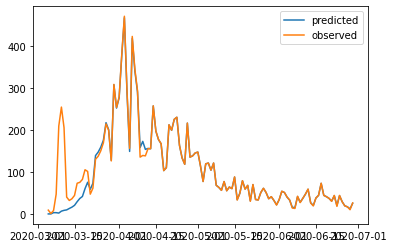

Step: 405, Time: 0.12682819366455078, Loss: 32447.08984375, Mean Expected Daily Hospit: 100.16959381103516
Step: 410, Time: 0.1294708251953125, Loss: 32330.564453125, Mean Expected Daily Hospit: 100.20893096923828
Step: 415, Time: 0.11986160278320312, Loss: 32215.123046875, Mean Expected Daily Hospit: 100.24856567382812
Step: 420, Time: 0.12360787391662598, Loss: 32100.712890625, Mean Expected Daily Hospit: 100.28844451904297
Step: 425, Time: 0.12029027938842773, Loss: 31987.306640625, Mean Expected Daily Hospit: 100.32862854003906
Step: 430, Time: 0.12092447280883789, Loss: 31874.8671875, Mean Expected Daily Hospit: 100.36906433105469
Step: 435, Time: 0.12174201011657715, Loss: 31763.353515625, Mean Expected Daily Hospit: 100.40962982177734
Step: 440, Time: 0.1194918155670166, Loss: 31652.75, Mean Expected Daily Hospit: 100.45063781738281
Step: 445, Time: 0.11748814582824707, Loss: 31543.00390625, Mean Expected Daily Hospit: 100.4913330078125
Step: 450, Time: 0.11814761161804199, Loss

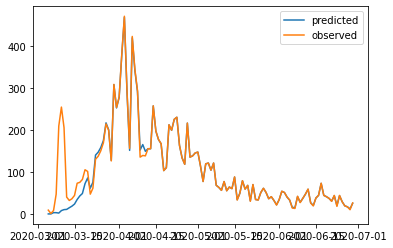

Step: 455, Time: 0.11885643005371094, Loss: 31325.998046875, Mean Expected Daily Hospit: 100.57376861572266
Step: 460, Time: 0.11577248573303223, Loss: 31218.673828125, Mean Expected Daily Hospit: 100.61509704589844
Step: 465, Time: 0.11973094940185547, Loss: 31112.08203125, Mean Expected Daily Hospit: 100.65646362304688
Step: 470, Time: 0.11885213851928711, Loss: 31006.189453125, Mean Expected Daily Hospit: 100.69795227050781
Step: 475, Time: 0.12317681312561035, Loss: 30900.94921875, Mean Expected Daily Hospit: 100.73958587646484
Step: 480, Time: 0.1204991340637207, Loss: 30796.3203125, Mean Expected Daily Hospit: 100.78109741210938
Step: 485, Time: 0.1199195384979248, Loss: 30692.240234375, Mean Expected Daily Hospit: 100.82249450683594
Step: 490, Time: 0.12487912178039551, Loss: 30588.666015625, Mean Expected Daily Hospit: 100.8641357421875
Step: 495, Time: 0.12276959419250488, Loss: 30485.53515625, Mean Expected Daily Hospit: 100.90563201904297
Step: 500, Time: 0.13190388679504395

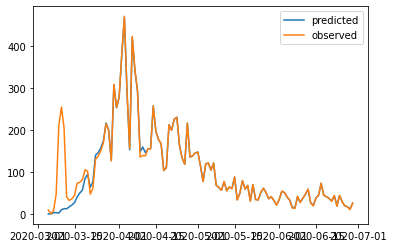

Step: 505, Time: 0.12006425857543945, Loss: 30280.3203125, Mean Expected Daily Hospit: 100.9889907836914
Step: 510, Time: 0.12025332450866699, Loss: 30178.083984375, Mean Expected Daily Hospit: 101.03034973144531
Step: 515, Time: 0.12685489654541016, Loss: 30075.994140625, Mean Expected Daily Hospit: 101.07201385498047
Step: 520, Time: 0.12384390830993652, Loss: 29973.951171875, Mean Expected Daily Hospit: 101.113525390625
Step: 525, Time: 0.11775851249694824, Loss: 29871.86328125, Mean Expected Daily Hospit: 101.15507507324219
Step: 530, Time: 0.12008833885192871, Loss: 29769.634765625, Mean Expected Daily Hospit: 101.19676208496094
Step: 535, Time: 0.12627220153808594, Loss: 29667.138671875, Mean Expected Daily Hospit: 101.2381591796875
Step: 540, Time: 0.1458876132965088, Loss: 29564.275390625, Mean Expected Daily Hospit: 101.27999114990234
Step: 545, Time: 0.12138819694519043, Loss: 29460.919921875, Mean Expected Daily Hospit: 101.32171630859375
Step: 550, Time: 0.12344002723693848

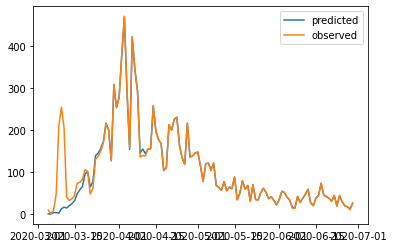

Step: 555, Time: 0.12372064590454102, Loss: 29252.19921875, Mean Expected Daily Hospit: 101.405517578125
Step: 560, Time: 0.11801862716674805, Loss: 29146.556640625, Mean Expected Daily Hospit: 101.44758605957031
Step: 565, Time: 0.12067198753356934, Loss: 29039.869140625, Mean Expected Daily Hospit: 101.489990234375
Step: 570, Time: 0.12443828582763672, Loss: 28931.9609375, Mean Expected Daily Hospit: 101.53245544433594
Step: 575, Time: 0.130049467086792, Loss: 28822.6953125, Mean Expected Daily Hospit: 101.5753173828125
Step: 580, Time: 0.13267993927001953, Loss: 28711.869140625, Mean Expected Daily Hospit: 101.61837005615234
Step: 585, Time: 0.12344813346862793, Loss: 28599.3203125, Mean Expected Daily Hospit: 101.66181182861328
Step: 590, Time: 0.12429499626159668, Loss: 28484.849609375, Mean Expected Daily Hospit: 101.70555877685547
Step: 595, Time: 0.12070512771606445, Loss: 28368.255859375, Mean Expected Daily Hospit: 101.74998474121094
Step: 600, Time: 0.12691020965576172, Loss

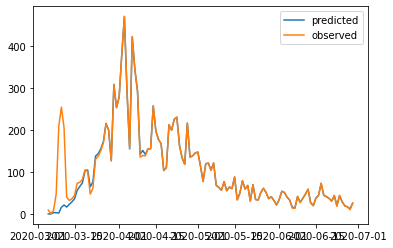

Step: 605, Time: 0.13047051429748535, Loss: 28127.837890625, Mean Expected Daily Hospit: 101.84001159667969
Step: 610, Time: 0.11905217170715332, Loss: 28003.5625, Mean Expected Daily Hospit: 101.88597869873047
Step: 615, Time: 0.1272575855255127, Loss: 27876.236328125, Mean Expected Daily Hospit: 101.93264770507812
Step: 620, Time: 0.12566518783569336, Loss: 27745.599609375, Mean Expected Daily Hospit: 101.98003387451172
Step: 625, Time: 0.12053942680358887, Loss: 27611.37890625, Mean Expected Daily Hospit: 102.02821350097656
Step: 630, Time: 0.1316981315612793, Loss: 27473.26953125, Mean Expected Daily Hospit: 102.077392578125
Step: 635, Time: 0.12722253799438477, Loss: 27330.953125, Mean Expected Daily Hospit: 102.12757110595703
Step: 640, Time: 0.11885523796081543, Loss: 27184.10546875, Mean Expected Daily Hospit: 102.17872619628906
Step: 645, Time: 0.12164545059204102, Loss: 27032.357421875, Mean Expected Daily Hospit: 102.23123168945312
Step: 650, Time: 0.13055086135864258, Loss:

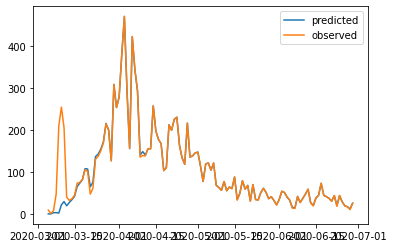

Step: 655, Time: 0.11601853370666504, Loss: 26712.669921875, Mean Expected Daily Hospit: 102.3401107788086
Step: 660, Time: 0.13204002380371094, Loss: 26543.8828125, Mean Expected Daily Hospit: 102.39680480957031
Step: 665, Time: 0.1187739372253418, Loss: 26368.552734375, Mean Expected Daily Hospit: 102.4549331665039
Step: 670, Time: 0.11932706832885742, Loss: 26186.19140625, Mean Expected Daily Hospit: 102.51506805419922
Step: 675, Time: 0.12906670570373535, Loss: 25996.296875, Mean Expected Daily Hospit: 102.57689666748047
Step: 680, Time: 0.1159827709197998, Loss: 25798.32421875, Mean Expected Daily Hospit: 102.64089965820312
Step: 685, Time: 0.12067484855651855, Loss: 25591.71484375, Mean Expected Daily Hospit: 102.70710754394531
Step: 690, Time: 0.12129044532775879, Loss: 25375.884765625, Mean Expected Daily Hospit: 102.77562713623047
Step: 695, Time: 0.12146258354187012, Loss: 25150.19921875, Mean Expected Daily Hospit: 102.84637451171875
Step: 700, Time: 0.1276383399963379, Loss

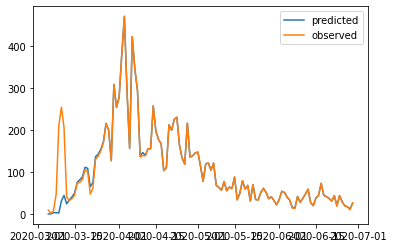

Step: 705, Time: 0.13203811645507812, Loss: 24666.693359375, Mean Expected Daily Hospit: 102.99687194824219
Step: 710, Time: 0.12043642997741699, Loss: 24407.52734375, Mean Expected Daily Hospit: 103.07610321044922
Step: 715, Time: 0.1315474510192871, Loss: 24135.83984375, Mean Expected Daily Hospit: 103.1590805053711
Step: 720, Time: 0.1186368465423584, Loss: 23850.935546875, Mean Expected Daily Hospit: 103.24518585205078
Step: 725, Time: 0.12119817733764648, Loss: 23552.1484375, Mean Expected Daily Hospit: 103.33451843261719
Step: 730, Time: 0.12441515922546387, Loss: 23238.845703125, Mean Expected Daily Hospit: 103.42781066894531
Step: 735, Time: 0.11793279647827148, Loss: 22910.423828125, Mean Expected Daily Hospit: 103.52485656738281
Step: 740, Time: 0.1258397102355957, Loss: 22566.376953125, Mean Expected Daily Hospit: 103.62593841552734
Step: 745, Time: 0.12359952926635742, Loss: 22206.302734375, Mean Expected Daily Hospit: 103.73065948486328
Step: 750, Time: 0.11975932121276855

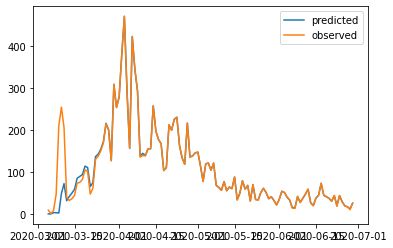

Step: 755, Time: 0.1302957534790039, Loss: 21437.23046875, Mean Expected Daily Hospit: 103.95195007324219
Step: 760, Time: 0.11881184577941895, Loss: 21028.31640625, Mean Expected Daily Hospit: 104.06819915771484
Step: 765, Time: 0.12054324150085449, Loss: 20603.63671875, Mean Expected Daily Hospit: 104.18815612792969
Step: 770, Time: 0.12049102783203125, Loss: 20163.953125, Mean Expected Daily Hospit: 104.31118774414062
Step: 775, Time: 0.1168367862701416, Loss: 19710.384765625, Mean Expected Daily Hospit: 104.43672180175781
Step: 780, Time: 0.12219452857971191, Loss: 19244.462890625, Mean Expected Daily Hospit: 104.56421661376953
Step: 785, Time: 0.1174154281616211, Loss: 18768.09765625, Mean Expected Daily Hospit: 104.6932144165039
Step: 790, Time: 0.11919093132019043, Loss: 18283.611328125, Mean Expected Daily Hospit: 104.82234954833984
Step: 795, Time: 0.12080049514770508, Loss: 17793.65234375, Mean Expected Daily Hospit: 104.950439453125
Step: 800, Time: 0.12050008773803711, Loss

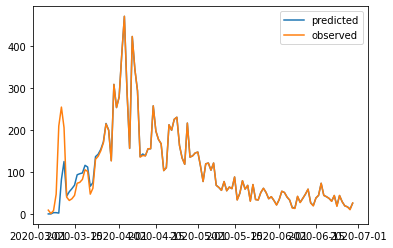

Step: 805, Time: 0.12522292137145996, Loss: 16809.123046875, Mean Expected Daily Hospit: 105.20023345947266
Step: 810, Time: 0.13361144065856934, Loss: 16320.669921875, Mean Expected Daily Hospit: 105.31884002685547
Step: 815, Time: 0.11884927749633789, Loss: 15838.68359375, Mean Expected Daily Hospit: 105.4320297241211
Step: 820, Time: 0.11907601356506348, Loss: 15365.8125, Mean Expected Daily Hospit: 105.53923034667969
Step: 825, Time: 0.127333402633667, Loss: 14904.34765625, Mean Expected Daily Hospit: 105.63882446289062
Step: 830, Time: 0.11711311340332031, Loss: 14456.208984375, Mean Expected Daily Hospit: 105.73035430908203
Step: 835, Time: 0.12550568580627441, Loss: 14022.9775390625, Mean Expected Daily Hospit: 105.81446838378906
Step: 840, Time: 0.12015867233276367, Loss: 13606.009765625, Mean Expected Daily Hospit: 105.89082336425781
Step: 845, Time: 0.11486601829528809, Loss: 13206.56640625, Mean Expected Daily Hospit: 105.95935821533203
Step: 850, Time: 0.12162184715270996, 

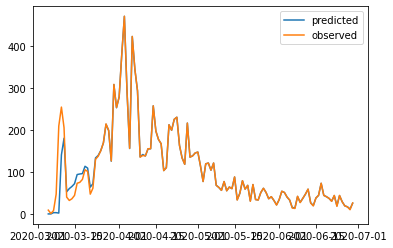

Step: 855, Time: 0.12286829948425293, Loss: 12465.3740234375, Mean Expected Daily Hospit: 106.07534790039062
Step: 860, Time: 0.11634349822998047, Loss: 12126.4013671875, Mean Expected Daily Hospit: 106.12371826171875
Step: 865, Time: 0.12404251098632812, Loss: 11810.43359375, Mean Expected Daily Hospit: 106.166015625
Step: 870, Time: 0.11868643760681152, Loss: 11518.783203125, Mean Expected Daily Hospit: 106.20223999023438
Step: 875, Time: 0.1292271614074707, Loss: 11252.4814453125, Mean Expected Daily Hospit: 106.2324447631836
Step: 880, Time: 0.12286949157714844, Loss: 11012.12109375, Mean Expected Daily Hospit: 106.25638580322266
Step: 885, Time: 0.11826395988464355, Loss: 10797.7177734375, Mean Expected Daily Hospit: 106.27442932128906
Step: 890, Time: 0.12770938873291016, Loss: 10608.6630859375, Mean Expected Daily Hospit: 106.28668212890625
Step: 895, Time: 0.12549448013305664, Loss: 10443.7294921875, Mean Expected Daily Hospit: 106.29270935058594
Step: 900, Time: 0.117683172225

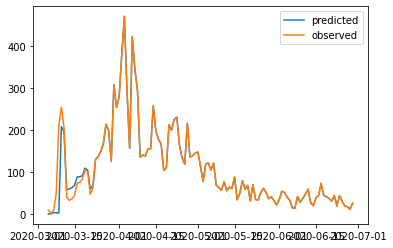

Step: 905, Time: 0.11626315116882324, Loss: 10178.810546875, Mean Expected Daily Hospit: 106.2875747680664
Step: 910, Time: 0.1208958625793457, Loss: 10074.3095703125, Mean Expected Daily Hospit: 106.27842712402344
Step: 915, Time: 0.1301746368408203, Loss: 9985.2216796875, Mean Expected Daily Hospit: 106.26537322998047
Step: 920, Time: 0.12342619895935059, Loss: 9909.212890625, Mean Expected Daily Hospit: 106.248779296875
Step: 925, Time: 0.1304917335510254, Loss: 9844.134765625, Mean Expected Daily Hospit: 106.23036193847656
Step: 930, Time: 0.11628866195678711, Loss: 9788.0966796875, Mean Expected Daily Hospit: 106.2105484008789
Step: 935, Time: 0.12054038047790527, Loss: 9739.4970703125, Mean Expected Daily Hospit: 106.18959045410156
Step: 940, Time: 0.12665939331054688, Loss: 9697.0087890625, Mean Expected Daily Hospit: 106.16812896728516
Step: 945, Time: 0.12395644187927246, Loss: 9659.560546875, Mean Expected Daily Hospit: 106.14692687988281
Step: 950, Time: 0.11971759796142578,

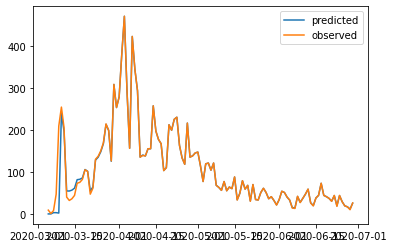

Step: 955, Time: 0.12069106101989746, Loss: 9596.541015625, Mean Expected Daily Hospit: 106.10513305664062
Step: 960, Time: 0.12307310104370117, Loss: 9569.7568359375, Mean Expected Daily Hospit: 106.08538055419922
Step: 965, Time: 0.12031030654907227, Loss: 9545.5185546875, Mean Expected Daily Hospit: 106.066162109375
Step: 970, Time: 0.11939239501953125, Loss: 9523.48046875, Mean Expected Daily Hospit: 106.04735565185547
Step: 975, Time: 0.12427854537963867, Loss: 9503.365234375, Mean Expected Daily Hospit: 106.02946472167969
Step: 980, Time: 0.1418004035949707, Loss: 9484.94140625, Mean Expected Daily Hospit: 106.01250457763672
Step: 985, Time: 0.1219630241394043, Loss: 9468.0146484375, Mean Expected Daily Hospit: 105.99610137939453
Step: 990, Time: 0.13409709930419922, Loss: 9452.4189453125, Mean Expected Daily Hospit: 105.98036193847656
Step: 995, Time: 0.12504291534423828, Loss: 9438.015625, Mean Expected Daily Hospit: 105.96531677246094
Step: 1000, Time: 0.12371706962585449, Los

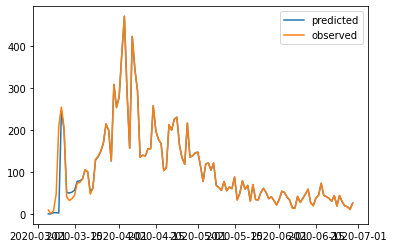

Step: 1005, Time: 0.1223142147064209, Loss: 9412.302734375, Mean Expected Daily Hospit: 105.9373779296875
Step: 1010, Time: 0.14774870872497559, Loss: 9400.7919921875, Mean Expected Daily Hospit: 105.92443084716797
Step: 1015, Time: 0.12383413314819336, Loss: 9390.0654296875, Mean Expected Daily Hospit: 105.91162872314453
Step: 1020, Time: 0.12375974655151367, Loss: 9380.0478515625, Mean Expected Daily Hospit: 105.89958190917969
Step: 1025, Time: 0.11790728569030762, Loss: 9370.673828125, Mean Expected Daily Hospit: 105.88816833496094
Step: 1030, Time: 0.13477611541748047, Loss: 9361.884765625, Mean Expected Daily Hospit: 105.87728118896484
Step: 1035, Time: 0.11871933937072754, Loss: 9353.6337890625, Mean Expected Daily Hospit: 105.8666763305664
Step: 1040, Time: 0.11797070503234863, Loss: 9345.869140625, Mean Expected Daily Hospit: 105.8563461303711
Step: 1045, Time: 0.11785268783569336, Loss: 9338.5517578125, Mean Expected Daily Hospit: 105.8465576171875
Step: 1050, Time: 0.12104701

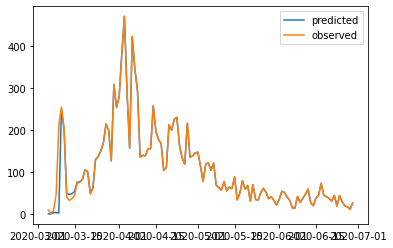

Step: 1055, Time: 0.11825704574584961, Loss: 9325.1123046875, Mean Expected Daily Hospit: 105.82831573486328
Step: 1060, Time: 0.12215495109558105, Loss: 9318.927734375, Mean Expected Daily Hospit: 105.81976318359375
Step: 1065, Time: 0.11606431007385254, Loss: 9313.0634765625, Mean Expected Daily Hospit: 105.81168365478516
Step: 1070, Time: 0.11678624153137207, Loss: 9307.490234375, Mean Expected Daily Hospit: 105.8038558959961
Step: 1075, Time: 0.11684966087341309, Loss: 9302.19140625, Mean Expected Daily Hospit: 105.79595947265625
Step: 1080, Time: 0.12057709693908691, Loss: 9297.1435546875, Mean Expected Daily Hospit: 105.78846740722656
Step: 1085, Time: 0.12079524993896484, Loss: 9292.3291015625, Mean Expected Daily Hospit: 105.78158569335938
Step: 1090, Time: 0.1201028823852539, Loss: 9287.7314453125, Mean Expected Daily Hospit: 105.7749252319336
Step: 1095, Time: 0.12412309646606445, Loss: 9283.3330078125, Mean Expected Daily Hospit: 105.76788330078125
Step: 1100, Time: 0.122971

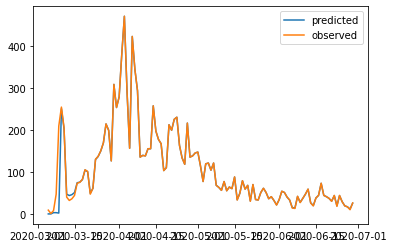

Step: 1105, Time: 0.1195371150970459, Loss: 9275.0830078125, Mean Expected Daily Hospit: 105.75550079345703
Step: 1110, Time: 0.12305283546447754, Loss: 9271.2099609375, Mean Expected Daily Hospit: 105.74977111816406
Step: 1115, Time: 0.127593994140625, Loss: 9267.4873046875, Mean Expected Daily Hospit: 105.74403381347656
Step: 1120, Time: 0.11792564392089844, Loss: 9263.904296875, Mean Expected Daily Hospit: 105.73847198486328
Step: 1125, Time: 0.12095999717712402, Loss: 9260.4541015625, Mean Expected Daily Hospit: 105.73298645019531
Step: 1130, Time: 0.12909150123596191, Loss: 9257.126953125, Mean Expected Daily Hospit: 105.72779083251953
Step: 1135, Time: 0.11753535270690918, Loss: 9253.9140625, Mean Expected Daily Hospit: 105.722900390625
Step: 1140, Time: 0.1253516674041748, Loss: 9250.8134765625, Mean Expected Daily Hospit: 105.71807861328125
Step: 1145, Time: 0.11943483352661133, Loss: 9247.814453125, Mean Expected Daily Hospit: 105.71321868896484


KeyboardInterrupt: ignored

In [17]:
epochs = 10000
model_parameter = [dict_param['prime_values']['alpha'], dict_param['prime_values']['phi']]

params_to_be_optimized = method.get_parameters() + model_parameter

optimizer = optim.Adam(params_to_be_optimized, lr=0.01)

for i in range(epochs):
  start_time = time.time()
  optimizer.zero_grad()

  # transform alphi, phi
  transform_prime_variables(dict_param)

  # forward pass
  expected = epid_model(population, R=method.calculate_R(), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)['newly_infected']

  # calc loss
  comparison_loss = dict_param['real_values']['phi'] * calc_mse(expected, observed)
  method_loss = method.calculate_loss()
  loss = comparison_loss + method_loss

  # backward pass
  loss.backward()
  optimizer.step()

  if i % 5==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected.cpu().detach().numpy().mean()}')
  
  if i % 50==0:
    plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
    plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
    plt.legend()
    plt.show()


# Evaluation

In [18]:
method.sigma

tensor(0.3722, device='cuda:0', grad_fn=<AddBackward0>)

In [19]:
method.R0

tensor(3.1464, device='cuda:0', grad_fn=<AddBackward0>)

In [20]:
dict_param['real_values']['phi']

tensor(23.5876, device='cuda:0', grad_fn=<AddBackward0>)

In [21]:
dict_param['real_values']['alpha']

tensor(0.0100, device='cuda:0', grad_fn=<AddBackward0>)

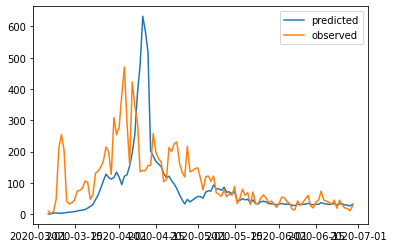

In [16]:
plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
plt.plot(df_obs['Date'], observed.cpu().detach().numpy(), label='observed')
plt.legend()
plt.show()